# Calculate Coupling Coefficients
Two split rings are placed in a broadside coupled configuration. The scalar model of each resonator is augmented by additional coefficients representing the coupling between them.

In [D. A. Powell et al, Phys. Rev. B 82, 155128 (2010)](http://dx.doi.org/10.1103/PhysRevB.82.155128) similar coefficients were calculated under the quasi-static approximation for a single mode only. Here the effects of retardation and radiation losses are included, as are the contributions of multiple modes of each ring.

In [1]:
# setup 2D and 3D plotting 
%matplotlib inline
from openmodes.ipython import matplotlib_defaults
matplotlib_defaults()
import matplotlib.pyplot as plt

import numpy as np

import os.path as osp

import openmodes
from openmodes.constants import c, eta_0
from openmodes.model import EfieModelMutualWeight
from openmodes.sources import PlaneWaveSource

## Creating geometry

As in previous examples, we load a pair of SRRs, place them in the simulation and visualise the result.

In [2]:
parameters={'inner_radius': 2.5e-3, 'outer_radius': 4e-3}

sim = openmodes.Simulation(notebook=True)
srr = sim.load_mesh(osp.join(openmodes.geometry_dir, "SRR.geo"), 
                    parameters=parameters,
                    mesh_tol=0.7e-3)

srr1 = sim.place_part(srr)
srr2 = sim.place_part(srr, location=[0e-3, 0e-3, 2e-3])
srr2.rotate([0, 0, 1], 180)

In [3]:
sim.plot_3d()

## Solving modes of individual rings
We find the singularities for the two identical rings.

In [4]:
start_s = 2j*np.pi*1e9

num_modes = 3

estimate = sim.estimate_poles(start_s, modes=num_modes, parts=[srr1, srr2], cauchy_integral=False)
refined = sim.refine_poles(estimate)

## Constructing the models

We now use these singularities to construct a model for each of the rings, where $n$ represents the ring number and $m$ represents the mode number. $s=j\omega$ is the complex frequency, $s_{n,m}$ is the complex resonant frequency of each mode and $\mathbf{V}_{n, m}$ is the corresponding current of the mode. The current on each ring is represented as a sum of modes

$$\mathbf{J}_{n} = \sum_m a_{n,m}\mathbf{V}_{n, m}$$

This results in the following coupled equation system for the modal coefficients on each ring

$$\frac{s_{n,m}}{s}\left(s-s_{n,m}\right)a_{n,m} + \sum_{n'\neq n}\sum_{m'}\left(sL_{m,n,m',n'} + \frac{1}{s}S_{m,n,m',n'}\right)a_{n',m'} = \mathbf{V}_{n, m}\cdot\mathbf{E}_{inc}$$

* The first term just says that the self-impedance of each mode is calculated directly from the pole expansion.
* The second term is the mutual inductance $L$ and capacitance $C = S^{-1}$ between each modes of different rings. These coefficients are obtained by weighting the relevant parts of the impedance matrix, e.g.:
$$L_{m,n,m',n'} = \mathbf{V}_{n, m} L_{n,n'}\mathbf{V}_{n', m'}$$
* The right hand side is just the projection of the incident field onto each mode

Here we construct two different models, one considering only the fundamental mode of each ring, and another considering the first and third modes. Due to symmetry, the second mode of each ring does not play a part in the hybridised modes which will be considered here.

In [5]:
dominant_modes = refined.select([0]).add_conjugates()
simple_model = EfieModelMutualWeight(dominant_modes)

full_modes = refined.select([0, 2]).add_conjugates()
full_model = EfieModelMutualWeight(full_modes)

## Solving scattering based on models
Now we iterate through all frequencies, and calculate the model parameters. Their accuracy is demonstrated by using them to calculate the extinction cross-section. For reference purposes, this will be compared with the direct calculation.

In [6]:
num_freqs = 200
freqs = np.linspace(5e9, 10e9, num_freqs)

plane_wave = PlaneWaveSource([0, 1, 0], [1, 0, 0], p_inc=1.0)

extinction_tot = np.empty(num_freqs, np.complex128)
extinction_single = np.empty(num_freqs, np.complex128)
extinction_full_model = np.empty((num_freqs, len(full_modes)), np.complex128)
extinction_simple_model = np.empty((num_freqs, len(dominant_modes)), np.complex128)

# store the mutual coupling coefficients for plotting purposes
mutual_L = np.empty(num_freqs, np.complex128)
mutual_S = np.empty(num_freqs, np.complex128)

simple_vr = dominant_modes.vr
simple_vl = dominant_modes.vl

full_vr = full_modes.vr
full_vl = full_modes.vl
                            
                            
for freq_count, s in sim.iter_freqs(freqs):
    impedance = sim.impedance(s)
    V = sim.source_vector(plane_wave, s)

    # For reference directly calculate extinction for the complete system, and for a single ring 
    extinction_tot[freq_count] = np.vdot(V, impedance.solve(V))    
    extinction_single[freq_count] = np.vdot(V["E", srr1], impedance[srr1, srr1].solve(V["E", srr1]))

    # calculate based on the simple model
    Z_model = simple_model.impedance(s)
    V_model = simple_vl.dot(V)
    I_model = Z_model.solve(V_model)
    extinction_simple_model[freq_count] = V.conj().dot(simple_vr*(I_model))    
    
    # calculate based on the full model
    Z_model = full_model.impedance(s)
    V_model = full_vl.dot(V)
    I_model = Z_model.solve(V_model)
    extinction_full_model[freq_count] = V.conj().dot(full_vr*(I_model))
    
    mutual_L[freq_count] = Z_model.matrices['L'][srr1, srr2][0, 0]
    mutual_S[freq_count] = Z_model.matrices['S'][srr1, srr2][0, 0]


## Accuracy of the models

The extinction cross section is now plotted for the pair of rings, using both the simpler model and the direct calculation. Additionally, the cross section of a single ring is shown. It can be seen that this fundamental mode of a single ring is split into two coupled modes. Due to the coupling impedance being complex, the hybridised modes have different widths.

In [7]:
# normalise the extinction to the cross-sectional area of each ring
area = np.pi*(parameters['outer_radius'])**2

Q_single = extinction_single/area
Q_pair = extinction_tot/area
Q_full_model = extinction_full_model/area
Q_simple_model = extinction_simple_model/area

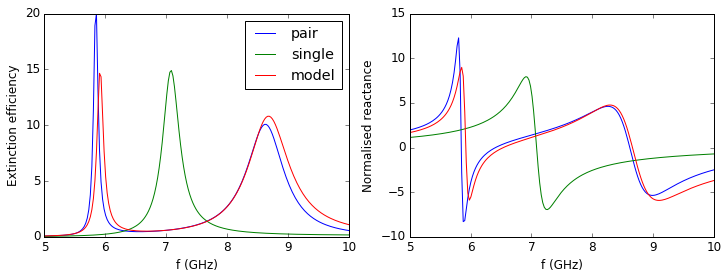

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freqs*1e-9, Q_pair.real, label='pair')
plt.plot(freqs*1e-9, Q_single.real, label='single')
plt.plot(freqs*1e-9, np.sum(Q_simple_model.real, axis=1), label='model')
plt.xlim(freqs[0]*1e-9, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.legend(loc='upper right')
plt.ylabel('Extinction efficiency')
plt.subplot(122)
plt.plot(freqs*1e-9, Q_pair.imag)
plt.plot(freqs*1e-9, Q_single.imag)
plt.plot(freqs*1e-9, np.sum(Q_simple_model.imag, axis=1))
plt.xlim(freqs[0]*1e-9, freqs[-1]*1e-9)
plt.ylabel('Normalised reactance')
plt.xlabel('f (GHz)')
plt.show()

In the above figure, it can be seen that the simple model of interaction between the rings gives quite good agreement. This can be improved by using the model which considers the two modes of each ring. While the modes on the same ring are independent of each other, between meta-atoms all modes couple to each other, thus there are 3 distinct coupling impedances, and two distinct self impedance terms.

The results of this model are plotted below, showing the improved accuracy by accounting for the higher-order mode.

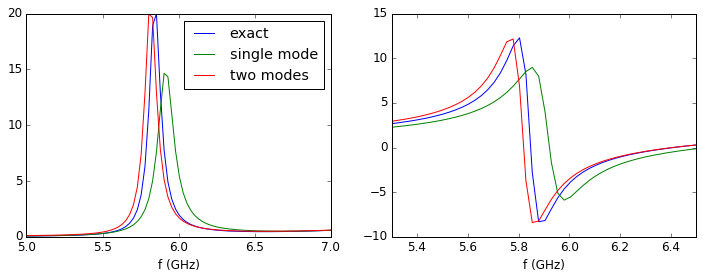

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freqs*1e-9, Q_pair.real, label='exact')
plt.plot(freqs*1e-9, np.sum(Q_simple_model.real, axis=1), label='single mode')
plt.plot(freqs*1e-9, np.sum(Q_full_model.real, axis=1), label='two modes')
plt.legend(loc="upper right")
plt.xlim(5.0, 7)
plt.xlabel('f (GHz)')
plt.subplot(122)
plt.plot(freqs*1e-9, Q_pair.imag)
plt.plot(freqs*1e-9, np.sum(Q_simple_model.imag, axis=1))
plt.plot(freqs*1e-9, np.sum(Q_full_model.imag, axis=1))
plt.xlim(5.3, 6.5)
plt.xlabel('f (GHz)')
plt.show()

## Coupling coefficients within the model

Now we can study the coupling coefficients between the dominant modes of the two rings. It can be seen that both $L_{mut}$ and $S_{mut}$ show quite smooth behaviour over this wide frequency range. This justifies the use of a low-order polynomial model for the interaction terms. This frequency variation is due to retardation, which is not very strong for such close separation.

However, the retardation is still strong enough to make the imaginary parts of these coupling terms non-negligible. These parts corresponds to the real part of the mutual impedance, and mean that the coupling affects not only the stored energy, but also the rate of energy loss due to radiation by the modes.

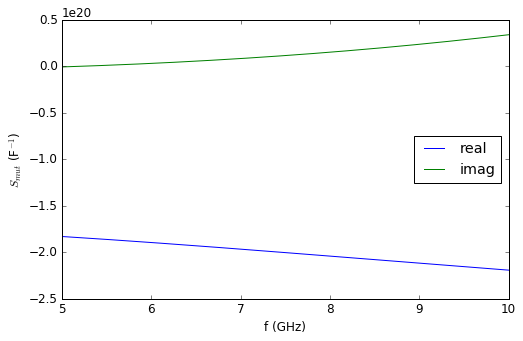

In [10]:
plt.figure()
plt.plot(freqs*1e-9, mutual_S.real, label='real')
plt.plot(freqs*1e-9, mutual_S.imag, label='imag')
plt.legend(loc="center right")
plt.ylabel('$S_{mut}$ (F$^{-1}$)')
plt.xlabel('f (GHz)')
plt.show()

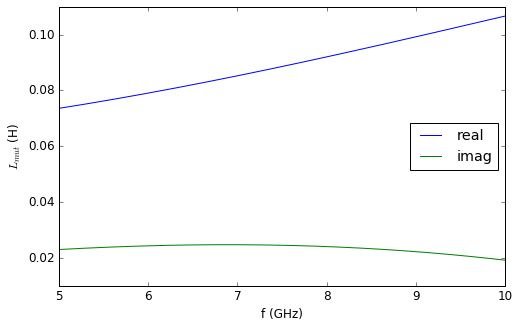

In [11]:
plt.figure()
plt.plot(freqs*1e-9, mutual_L.real, label='real')
plt.plot(freqs*1e-9, mutual_L.imag, label='imag')
plt.legend(loc="center right")
plt.ylabel('$L_{mut}$ (H)')
plt.xlabel('f (GHz)')
plt.show()

It can be seen that these are quite smooth functions, so they could be fitted by a low-order polynomial if required.